# Clip

https://huggingface.co/docs/transformers/model_doc/clip

In [ ]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

2025-09-14 18:06:30.413180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757873190.605844      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757873190.666913      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda


In [2]:
data_root = Path("/kaggle/input/flickr8k")
images_root = data_root / "Images"
captions_file = data_root / "captions.txt"

df = pd.read_csv(captions_file, sep=",", names=["image", "caption"], skiprows=1)
print(df.head())

df['image'] = df['image'].str.strip()


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, df, images_root, processor):
        self.df = df.reset_index(drop=True)
        self.images_root = Path(images_root)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.images_root / row['image']
        caption = row['caption']

        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(
            text=caption,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        return {k: v.squeeze(0) for k, v in inputs.items()}


In [4]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

df_small = df.sample(2000, random_state=42).reset_index(drop=True)

train_df, val_df = train_test_split(df_small, test_size=0.1, random_state=42)

train_ds = FlickrDataset(train_df, images_root, processor)
val_ds = FlickrDataset(val_df, images_root, processor)

def collate_fn(batch):
    return {
        "input_ids": torch.stack([b['input_ids'] for b in batch]),
        "attention_mask": torch.stack([b['attention_mask'] for b in batch]),
        "pixel_values": torch.stack([b['pixel_values'] for b in batch]),
    }

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

![Описание изображения](https://miro.medium.com/1*tg7akErlMSyCLQxrMtQIYw.png)

In [ ]:
temp = nn.Parameter(torch.tensor(1.0))
optimizer = torch.optim.AdamW(list(model.parameters())+[temp``], lr=5e-6, weight_decay=0.01)

def clip_loss(image_embeds, text_embeds, temperature):
    image_embeds = image_embeds / image_embeds.norm(dim=1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(dim=1, keepdim=True)
    logits = (image_embeds @ text_embeds.t()) * torch.exp(temperature)
    labels = torch.arange(logits.size(0), device=logits.device)
    loss_i2t = nn.CrossEntropyLoss()(logits, labels)
    loss_t2i = nn.CrossEntropyLoss()(logits.t(), labels)
    return (loss_i2t + loss_t2i) / 2.0


In [8]:
epochs = 3  # можно поставить 1-3 для теста

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    train_loss = 0.0

    for step, batch in enumerate(pbar):
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )

        loss = clip_loss(outputs.image_embeds, outputs.text_embeds, temp)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        avg_loss = train_loss / (step + 1)

        # обновляем прогресс-бар
        pbar.set_postfix(loss=avg_loss)

    # --- Валидация ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values,
                return_dict=True
            )

            loss = clip_loss(outputs.image_embeds, outputs.text_embeds, temp)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f}, val_loss={val_loss:.4f}")


Epoch 1/3:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1: train_loss=1.8539, val_loss=2.1296


Epoch 2/3:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2: train_loss=1.6280, val_loss=2.0661


Epoch 3/3:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3: train_loss=1.5161, val_loss=2.0494


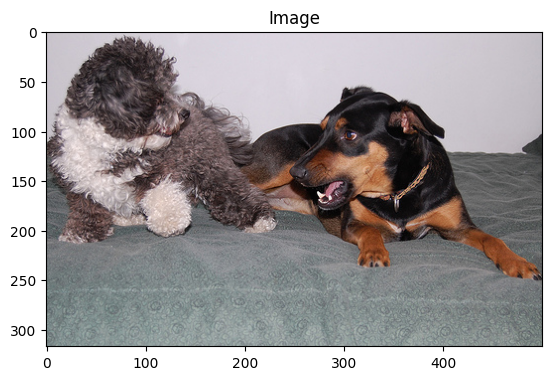

Истинный caption: Two dogs play together on the bed .
Лучший найденный: Two dogs play together on the bed .


In [18]:
from matplotlib import pyplot as plt

def encode_image(img: Image.Image):
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu()

def encode_texts(texts):
    inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        emb = model.get_text_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu()

sample = val_df.sample(1).iloc[0]
img = Image.open(images_root / sample['image']).convert("RGB")

im = Image.open(images_root / sample['image'])
plt.imshow(im)
plt.title("Image")
plt.show()

true_caption = sample['caption']

candidates = [
    true_caption,
    "A cat sleeping on a couch",
    "A group of people riding bikes",
    "A plate of food on the table",
    "A man standing",
    "Random word"
]

img_emb = encode_image(img)
txt_embs = encode_texts(candidates)
sims = (img_emb @ txt_embs.T).squeeze(0)
best_idx = sims.argmax().item()

print("Истинный caption:", true_caption)
print("Лучший найденный:", candidates[best_idx])
